<a href="https://colab.research.google.com/github/Konstantinosil/Tsioutsios-Linardatos-Persistence-in-the-Output-Gap-for-the-G7/blob/main/Shadow_Rates_and_Output_Gap_Persistence_for_the_U_S_Tsioutsios_%26_Linardatos_2nd_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading workbook...
Using sheet: United States

[Table S1] Summary statistics (monthly, winsorized 1–99 pct, non-standardized):
                   N   Mean     SD    Min     Max   Skew   Kurt
Inflation_yoy  388.0  2.551  1.521 -1.049   7.939  1.080  2.800
Unemployment   400.0  5.783  1.659  3.500  10.002  0.876  0.047
IP_log         400.0  4.482  0.160  4.112   4.644 -1.140 -0.025
SR             400.0  2.349  2.755 -2.986   8.136 -0.031 -1.100
ELB share (SR<0): 0.230

[Table S2] Summary statistics (quarterly, last-month-of-quarter alignments):
                      N   Mean     SD    Min     Max   Skew   Kurt
Inflation_4Q_yoy  130.0  2.542  1.547 -1.388   8.617  1.150  3.709
SR                134.0  2.374  2.754 -2.889   7.951 -0.044 -1.120
GDP_log           134.0  9.644  0.235  9.206  10.025 -0.351 -0.951

Fitting gaps…
DFM correlation (with SR vs no SR): 0.337

[T1] Fractional d (LW at 0.65), CI, IRF-based half-life (months):
             d_LW  ci_lo  ci_hi  half_life_IRF  d_GPH
gap 

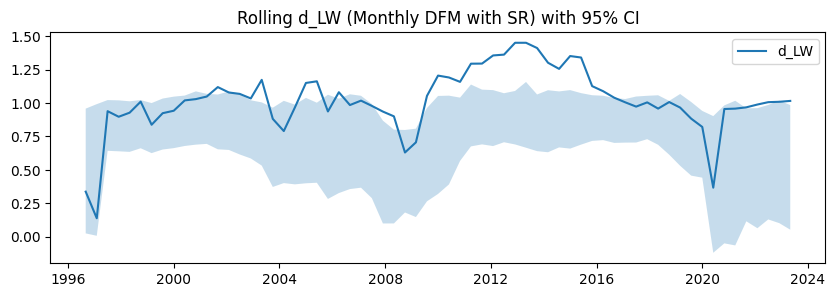


[T3-no SR] Rolling OLS (HAC): d_t on Ease & ELB_share
                            OLS Regression Results                            
Dep. Variable:                   d_LW   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     10.08
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           0.000162
Time:                        02:21:24   Log-Likelihood:                 22.739
No. Observations:                  65   AIC:                            -39.48
Df Residuals:                      62   BIC:                            -32.96
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

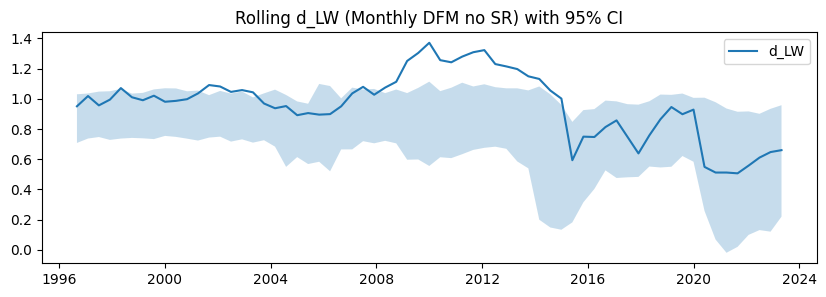

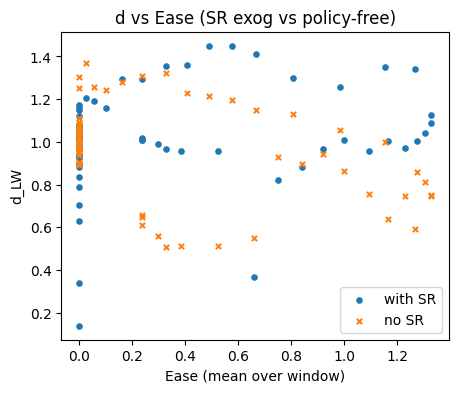


[T3-compare] OLS coefficients (HAC) across DFM specs:
             beta_Ease  p_Ease  beta_ELB  p_ELB     R2
DFM with SR     -1.233     0.0     2.054    0.0  0.477
DFM no SR       -1.089     0.0     1.371    0.0  0.377

[T2b-M_DFM_SR] ELB split d (Monthly DFM):
          n   d_LW
ELB      92  0.989
nonELB  308  0.270

[T2b-M_DFM_noSR] ELB split d (Monthly DFM):
          n   d_LW
ELB      92  0.899
nonELB  308  0.947

[T4] Taylor (HAC), gap standardized (UC gap without SR on RHS):
alpha     0.021097
rho       0.954205
phi_pi    0.144402
phi_y    -0.026851
dtype: float64

Rolling ARX windows: 48, mean delta_t=0.343


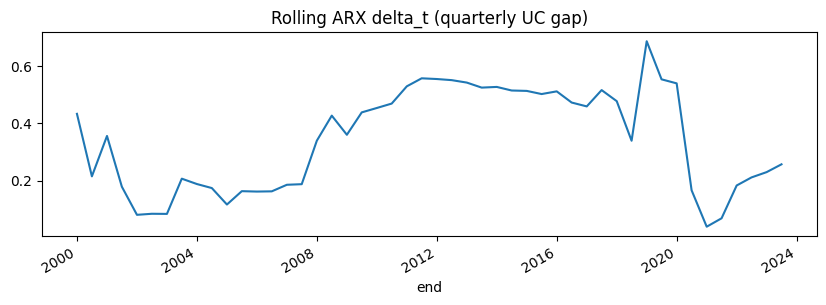


--- DONE (paper view + SR endogeneity fix for Taylor) ---


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy import optimize, linalg
import statsmodels.api as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt
from scipy.special import gammaln
from scipy.stats import skew, kurtosis

# ------------------- Paths & global options -------------------
DATA_PATH  = "/content/total dataset new.xlsx"
SHEET_NAME = None

MIN_OBS_FRAC = 40
BW_EXPS   = (0.55, 0.65, 0.80)
BW_CENTER = 0.65

MBB_B_BASE = 299
MBB_L_BASE = 8
MBB_B_ELB  = 999
MBB_L_ELB  = 12
RNG_SEED   = 123

ROLL_M=80;  ROLL_STEP_M=5
ROLL_Q=40;  ROLL_STEP_Q=2
ROLL_CI_B=199; ROLL_CI_L=8

HAM_H=8; HAM_P4=4; HAM_P8=8
PI_STAR=2.0; NW_LAGS_Q=4

# ------------------- Utils -------------------
def zscore(s):
    s = pd.to_numeric(s, errors="coerce").astype(float)
    m, sd = s.mean(), s.std()
    return (s-m)/sd if (sd and sd>0) else s*0.0

def winsorize(s, p=(0.01,0.99)):
    lo, hi = s.quantile([p[0],p[1]])
    return s.clip(lo, hi)

def half_life_irf_from_d(d, step_months=1, J=20000):
    """
    Effective half-life for a fractional process, based on ARFIMA(0,d,0) IRFs:
    find smallest h with psi_h <= 0.5. step_months=1 (monthly) or 3 (quarterly).
    """
    if d is None or not np.isfinite(d) or d <= 0:
        return np.nan
    j = np.arange(0, J+1, dtype=np.float64)
    logpsi = gammaln(j + d) - gammaln(j + 1.0) - gammaln(d)
    psi = np.exp(logpsi)
    idx = np.where(psi <= 0.5)[0]
    if idx.size == 0:
        return np.nan
    h = int(idx[0])
    return h * step_months

def toME(x): return pd.to_datetime(x, errors="coerce").to_period("M").to_timestamp(how="end")
def toQE(x): return pd.to_datetime(x, errors="coerce").to_period("Q").to_timestamp(how="end")

PAIR_POSITIONS=[("gdp",0,1),("cpi",2,3),("rate",4,5),("unemp",6,7),("ip",8,9),("shadow",10,11)]

def parse_sheet(df):
    out={}
    for key,dcol,vcol in PAIR_POSITIONS:
        if vcol<df.shape[1]:
            dt=pd.to_datetime(df.iloc[:,dcol],errors="coerce"); val=pd.to_numeric(df.iloc[:,vcol],errors="coerce")
            s=pd.Series(val.values,index=dt).dropna()
            s=s[~s.index.duplicated(keep="last")].sort_index()
            if s.notna().sum()>=3: out[key]=s
    return out

def panel_monthly(series):
    keys=[k for k in ["cpi","rate","unemp","ip","shadow"] if k in series]
    idx=None
    for k in keys:
        ii=toME(series[k].index)
        idx = ii if idx is None else idx.union(ii)
    idx=pd.DatetimeIndex(idx).sort_values()
    df=pd.DataFrame(index=idx)
    for k in keys: df[k]=pd.Series(series[k].values,index=toME(series[k].index)).reindex(idx)
    return df

def gdp_q_log(series):
    g=pd.Series(series["gdp"].values,index=toQE(series["gdp"].index)).sort_index()
    g=g[g>0]
    return np.log(g).rename("gdp_log")

def q_from_m_last(df_m):
    qm=df_m.copy(); qm["q_end"]=qm.index.to_period("Q").to_timestamp(how="end")
    q=qm.groupby("q_end").last(); q.index.name=None
    return q

# ------------------- Long-memory estimators -------------------
def default_m(n,exp=0.65): return int(np.clip(n**exp, 10, max(20,n//2)))

def periodogram(x):
    x=np.asarray(x,float); x=x-np.nanmean(x); n=len(x)
    fx=np.fft.rfft(x,n=n)[1:]; I=(1/(2*np.pi*n))*(fx*np.conj(fx)).real
    w=2*np.pi*np.arange(1,len(I)+1)/n
    I=np.clip(I,1e-12,np.inf); return w,I

def gph(x,exp=0.65):
    s=pd.Series(x).dropna(); n=len(s)
    if n<MIN_OBS_FRAC: return np.nan,np.nan,{"m":None}
    m=default_m(n,exp); w,I=periodogram(s.values); w_m=w[:m]; I_m=I[:m]
    y=np.log(I_m); X=np.vstack([np.ones(len(w_m)),-2*np.log(2*np.sin(w_m/2))]).T
    mask=np.isfinite(y)&np.all(np.isfinite(X),axis=1); y=y[mask]; X=X[mask,:]
    if len(y)<10: return np.nan,np.nan,{"m":int(m)}
    beta=linalg.lstsq(X,y)[0]; d=float(beta[1])
    resid=y-(X@beta); s2=(resid**2).sum()/max(len(y)-2,1); cov=s2*np.linalg.inv(X.T@X)
    se=float(np.sqrt(max(cov[1,1],0.0))); return d,se,{"m":int(m)}

def lw(x,exp=0.65):
    s=pd.Series(x).dropna(); n=len(s)
    if n<MIN_OBS_FRAC: return np.nan,np.nan,{"m":None,"success":False}
    m=default_m(n,exp); w=2*np.pi*np.arange(1,m+1)/n
    fx=np.fft.rfft(s.values,n=n)[1:m+1]; I=(1/(2*np.pi*n))*(fx*np.conj(fx)).real; I=np.clip(I,1e-12,np.inf)
    lam=2*np.sin(w/2)
    def S(d): return np.log(np.mean(I*(lam**(2*d))))-(2*d)*np.log(lam).mean()
    opt=optimize.minimize_scalar(S,bounds=(-0.45,1.45),method='bounded'); d=float(opt.x); se=float(1.0/(2.0*np.sqrt(m)))
    return d,se,{"m":int(m),"success":bool(opt.success)}

def frac_grid(series, exps=BW_EXPS):
    s=pd.Series(series).dropna(); rows=[]
    for e in exps:
        d_lw,se_lw,_=lw(s.values,exp=e)
        d_g ,se_g ,_=gph(s.values,exp=e)
        rows.append([e,d_lw,se_lw,d_g,se_g])
    return pd.DataFrame(rows,columns=["exp","d_LW","se_LW","d_GPH","se_GPH"])

def frac_summary(series):
    grid=frac_grid(series); d=grid.loc[grid["exp"]==BW_CENTER,"d_LW"].iloc[0]
    se=grid.loc[grid["exp"]==BW_CENTER,"se_LW"].iloc[0]
    ci=(d-1.96*se,d+1.96*se); return d,ci,grid

# ------------------- Bootstrap & rolling -------------------
def mbb_diff(x_ser,y_ser,L=8,B=299,seed=RNG_SEED):
    x=pd.Series(x_ser).dropna(); y=pd.Series(y_ser).dropna()
    common=x.index.intersection(y.index); x=x.loc[common]; y=y.loc[common]; n=len(x)
    if n<MIN_OBS_FRAC: return None
    def est(z): return lw(pd.Series(z).dropna().values)[0]
    d0,d1=est(x),est(y); d_obs=d1-d0
    rng=np.random.default_rng(seed); blocks=[np.arange(i,min(i+L,n)) for i in range(0,n-L+1)]
    diffs=[]
    for _ in range(B):
        idx=[]
        while len(idx)<n: idx.extend(blocks[rng.integers(0,len(blocks))])
        idx=np.asarray(idx[:n],int); xb=x.iloc[idx].reset_index(drop=True); yb=y.iloc[idx].reset_index(drop=True)
        diffs.append(est(yb)-est(xb))
    diffs=np.array(diffs); p=(np.sum(np.abs(diffs)>=np.abs(d_obs))+1)/(B+1)
    return d_obs,p

def rolling_lw(series, W, step):
    s=pd.Series(series).dropna(); idx=s.index; rows=[]; i=0
    while i+W<=len(s):
        seg=s.iloc[i:i+W]; d,se,_=lw(seg.values,exp=BW_CENTER)
        rows.append({"start":idx[i],"end":idx[i+W-1],"d_LW":d}); i+=step
    return pd.DataFrame(rows)

def rolling_ci(series, W, step, B=ROLL_CI_B, L=ROLL_CI_L, seed=RNG_SEED):
    s=pd.Series(series).dropna(); idx=s.index; rows=[]; rng=np.random.default_rng(seed); i=0
    while i+W<=len(s):
        seg=s.iloc[i:i+W]; d_hat,_,_=lw(seg.values,exp=BW_CENTER); n=len(seg)
        blocks=[np.arange(j,min(j+L,n)) for j in range(0,n-L+1)]
        boots=[]
        for _ in range(B):
            idb=[]
            while len(idb)<n: idb.extend(blocks[rng.integers(0,len(blocks))])
            idb=np.asarray(idb[:n],int); boots.append(lw(seg.values[idb],exp=BW_CENTER)[0])
        lo,hi=np.nanpercentile(boots,[2.5,97.5])
        rows.append({"start":idx[i],"end":idx[i+W-1],"d_LW":d_hat,"ci_lo":lo,"ci_hi":hi}); i+=step
    return pd.DataFrame(rows)

def window_stat(s,start,end,func=np.mean):
    ss=s.loc[(s.index>=start)&(s.index<=end)]
    return func(ss) if not ss.empty else np.nan

# ------------------- Transform builders (MISSING BEFORE) -------------------
def build_transforms(panel_m, gdp_log_q):
    """
    Build monthly transforms used in the DFM and summaries:
    - infl_yoy: 12m CPI inflation (%), winsorized 1–99 pct
    - ip_log: log IP, winsorized
    - unemp: level, winsorized
    - SR, ELB dummy
    - gdp_log reindexed to monthly for sparse inclusion
    Returns: (trans_m, Xstd) where Xstd are z-scores of [ip_log, unemp, infl_yoy]
    """
    out=pd.DataFrame(index=panel_m.index)
    if "cpi" in panel_m:
        p=panel_m["cpi"].where(panel_m["cpi"]>0); pl=np.log(p)
        out["infl_yoy"]=100*(pl-pl.shift(12))
        out["infl_q_ann"]=(pl-pl.shift(3))*(400/3.0)
    if "ip" in panel_m:
        out["ip_log"]=np.log(panel_m["ip"].where(panel_m["ip"]>0))
    if "unemp" in panel_m:
        out["unemp"]=panel_m["unemp"]
    if "shadow" in panel_m:
        out["SR"]=panel_m["shadow"]; out["ELB"]=(out["SR"]<0).astype(float)

    for c in ["infl_yoy","ip_log","unemp"]:
        if c in out:
            out[c]=winsorize(out[c],(0.01,0.99))

    out["gdp_log"]=gdp_log_q.reindex(out.index)
    Xstd=out[["ip_log","unemp","infl_yoy"]].apply(zscore)
    return out,Xstd

def elb_split_d(series, elb):
    s=pd.Series(series).dropna()
    m=pd.Series(elb).reindex(s.index).dropna()
    s=s.loc[m.index]; elb=m.astype(bool)
    s_elb=s[elb]; s_non=s[~elb]
    dE,_ ,_=lw(s_elb.values) if len(s_elb)>=MIN_OBS_FRAC else (np.nan,np.nan,{})
    dN,_ ,_=lw(s_non.values) if len(s_non)>=MIN_OBS_FRAC else (np.nan,np.nan,{})
    return dE,len(s_elb), dN,len(s_non)

# ------------------- Models -------------------
def fit_uc_q(y_log_q, sr_q):
    """UC with SR as exogenous (policy-aware) — used for d, not for Taylor."""
    y=y_log_q.dropna(); ex=sr_q.reindex(y.index)
    mod=UnobservedComponents(endog=y, level='local linear trend', cycle=True,
                             stochastic_level=True, stochastic_trend=True, stochastic_cycle=True,
                             damped_cycle=False, exog=ex)
    try: res=mod.fit(disp=False,maxiter=800)
    except Exception: res=mod.fit(method='nm',disp=False,maxiter=800)
    try: gap=res.cycle.smoothed.rename("gap_Q_UC")
    except Exception:
        lvl  =res.level.smoothed if hasattr(res,"level") else 0.0
        trnd =res.trend.smoothed if hasattr(res,"trend") else 0.0
        gap  =(y-(lvl+trnd)).rename("gap_Q_UC")
    return gap.dropna()

def fit_uc_q_noexog(y_log_q):
    """UC without SR (policy-free) — to be used on RHS of Taylor."""
    y=y_log_q.dropna()
    mod=UnobservedComponents(endog=y, level='local linear trend', cycle=True,
                             stochastic_level=True, stochastic_trend=True, stochastic_cycle=True,
                             damped_cycle=False, exog=None)
    try: res=mod.fit(disp=False,maxiter=800)
    except Exception: res=mod.fit(method='nm',disp=False,maxiter=800)
    try: gap=res.cycle.smoothed.rename("gap_Q_UC_noSR")
    except Exception:
        lvl  =res.level.smoothed if hasattr(res,"level") else 0.0
        trnd =res.trend.smoothed if hasattr(res,"trend") else 0.0
        gap  =(y-(lvl+trnd)).rename("gap_Q_UC_noSR")
    return gap.dropna()

def hp_gap_q(y_log_q, lam=1600):
    cyc,_=hpfilter(y_log_q.dropna(),lamb=lam); return cyc.rename(f"gap_Q_HP_{lam}")

def ham_gap_q(y_log_q, h=8, p=4):
    y=y_log_q.dropna(); df=pd.DataFrame({"y":y})
    for i in range(p): df[f"L{i+1}"]=y.shift(i+1)
    df["y_lead"]=y.shift(-h); df=df.dropna()
    Y=df["y_lead"]; X=sm.add_constant(df[[f"L{i+1}" for i in range(p)]])
    r=sm.OLS(Y,X).fit(); fitted=pd.Series(r.predict(X),index=df.index)
    gap_lead=Y-fitted; gap_t=gap_lead.shift(h).rename(f"gap_Q_HAM_h{h}_p{p}")
    return gap_t.dropna()

def fit_dfm_m(Xstd, gdp_sparse_m, sr_m, use_sr_exog=True):
    X=pd.DataFrame(index=Xstd.index)
    for c in ["ip_log","unemp","infl_yoy"]:
        if c in Xstd and Xstd[c].notna().sum()>=20: X[c]=Xstd[c]
    if gdp_sparse_m.notna().sum()>=10: X["gdp_sparse"]=gdp_sparse_m
    keep=[c for c in X.columns if X[c].notna().sum()>=20]; X=X[keep]
    if X.shape[1]==0: return None
    exog=sr_m.reindex(X.index).to_frame("SR") if use_sr_exog else None
    mod=DynamicFactor(endog=X,k_factors=1,factor_order=1,error_order=1,
                      enforce_stationarity=False, exog=exog)
    try: res=mod.fit(disp=False,maxiter=800)
    except Exception: res=mod.fit(method='nm',disp=False,maxiter=800)
    fac=res.factors.filtered
    s=fac.iloc[:,0] if isinstance(fac,pd.DataFrame) else (fac if isinstance(fac,pd.Series)
        else pd.Series(np.asarray(fac).reshape(-1)[:len(X.index)], index=X.index))
    gap=((s-s.mean())/s.std()).rename("gap_M_DFM").dropna()
    return gap

# ------------------- Taylor & rolling ARX helpers -------------------
def to_q_last(s_m):
    if s_m is None or s_m.dropna().empty: return None
    d=s_m.dropna(); q=d.groupby(d.index.to_period("Q")).last(); q.index=q.index.to_timestamp(how="end"); return q

def taylor_ols(sr_q, pi_q, gap_q, std_gap=True):
    g=(gap_q-gap_q.mean())/gap_q.std() if std_gap else gap_q.copy()
    df=pd.concat([sr_q.rename("SR"),pi_q.rename("pi"),g.rename("gap")],axis=1).dropna()
    df["SR_L1"]=df["SR"].shift(1); df["pi_gap"]=df["pi"]-PI_STAR; df=df.dropna()
    Y=df["SR"]; X=sm.add_constant(df[["SR_L1","pi_gap","gap"]])
    res=sm.OLS(Y,X).fit(cov_type="HAC",cov_kwds={"maxlags":NW_LAGS_Q})
    pars=res.params.rename({"const":"alpha","SR_L1":"rho","pi_gap":"phi_pi","gap":"phi_y"})
    return pars,res

def rolling_arx(gap_q, sr_q, W=ROLL_Q, step=ROLL_STEP_Q):
    g=pd.Series(gap_q).dropna(); sr=sr_q.reindex(g.index)
    rows=[]; i=0
    while i+W<=len(g):
        seg=g.iloc[i:i+W]; sr_seg=sr.iloc[i:i+W]
        df=pd.DataFrame({"g":seg,"g_l1":seg.shift(1),"SR":sr_seg}).dropna()
        if df.shape[0]>=10:
            r=sm.OLS(df["g"],sm.add_constant(df[["g_l1","SR"]])).fit(cov_type="HAC",cov_kwds={"maxlags":2})
            rows.append({"end":df.index[-1],"delta":r.params.get("g_l1",np.nan)})
        i+=step
    return pd.DataFrame(rows).set_index("end")

# ------------------- Main -------------------
def summarize_series(s):
    s = pd.to_numeric(pd.Series(s).dropna(), errors="coerce").dropna()
    if s.empty:
        return pd.Series({"N":0,"Mean":np.nan,"SD":np.nan,"Min":np.nan,"Max":np.nan,"Skew":np.nan,"Kurt":np.nan})
    return pd.Series({
        "N":   int(s.shape[0]),
        "Mean": s.mean(),
        "SD":   s.std(ddof=1),
        "Min":  s.min(),
        "Max":  s.max(),
        "Skew": skew(s, bias=False),
        "Kurt": kurtosis(s, fisher=True, bias=False)  # excess
    })

def main():
    print("Loading workbook...")
    xl=pd.ExcelFile(DATA_PATH)
    name=SHEET_NAME if (SHEET_NAME in xl.sheet_names) else xl.sheet_names[0]
    df_raw=pd.read_excel(xl, sheet_name=name)
    print(f"Using sheet: {name}")

    S=parse_sheet(df_raw)
    panel_m=panel_monthly(S)
    gdp_log_q=gdp_q_log(S)

    panel_m["SR"]=panel_m["shadow"]; panel_m["ELB"]=(panel_m["SR"]<0).astype(float)
    panel_q=q_from_m_last(panel_m); sr_q=panel_q["SR"].reindex(gdp_log_q.index)

    # ---------- Monthly transforms & Xstd ----------
    trans_m, Xstd = build_transforms(panel_m, gdp_log_q)

    # ---------- Summary statistics (S1/S2) ----------
    monthly_inputs = pd.DataFrame(index=trans_m.index)
    monthly_inputs["Inflation_yoy"] = trans_m["infl_yoy"]
    monthly_inputs["Unemployment"]  = trans_m["unemp"]
    monthly_inputs["IP_log"]        = trans_m["ip_log"]
    monthly_inputs["SR"]            = trans_m["SR"]

    S1 = monthly_inputs.apply(summarize_series).T
    elb_share = float((trans_m["SR"]<0).mean())
    print("\n[Table S1] Summary statistics (monthly, winsorized 1–99 pct, non-standardized):")
    print(S1.round(3))
    print(f"ELB share (SR<0): {elb_share:.3f}")

    quarterly_inputs = pd.DataFrame(index=q_from_m_last(trans_m).index)
    cpi_q_last = to_q_last(panel_m["cpi"])
    if cpi_q_last is not None:
        quarterly_inputs["Inflation_4Q_yoy"] = 100*(np.log(cpi_q_last)-np.log(cpi_q_last.shift(4)))
    quarterly_inputs["SR"] = panel_q["SR"]
    quarterly_inputs = pd.concat([quarterly_inputs, gdp_log_q.rename("GDP_log")], axis=1)
    S2 = quarterly_inputs.apply(summarize_series).T
    print("\n[Table S2] Summary statistics (quarterly, last-month-of-quarter alignments):")
    print(S2.round(3))

    # ---------- GAPS ----------
    print("\nFitting gaps…")
    gap_Q_uc      = fit_uc_q(gdp_log_q, sr_q)          # policy-aware UC (with SR)
    gap_Q_uc_noSR = fit_uc_q_noexog(gdp_log_q)         # policy-free UC (no SR) — for Taylor RHS
    gap_Q_hp_1600 = hp_gap_q(gdp_log_q,1600)
    gap_Q_hp_4000 = hp_gap_q(gdp_log_q,4000)
    gap_Q_ham_p4  = ham_gap_q(gdp_log_q,HAM_H,HAM_P4)
    gap_Q_ham_p8  = ham_gap_q(gdp_log_q,HAM_H,HAM_P8)

    gap_M_dfm_SR    = fit_dfm_m(Xstd, trans_m["gdp_log"], trans_m["SR"], use_sr_exog=True)
    gap_M_dfm_noSR  = fit_dfm_m(Xstd, trans_m["gdp_log"], trans_m["SR"], use_sr_exog=False)

    if (gap_M_dfm_SR is not None) and (gap_M_dfm_noSR is not None):
        commonM = gap_M_dfm_SR.index.intersection(gap_M_dfm_noSR.index)
        corrM = gap_M_dfm_SR.loc[commonM].corr(gap_M_dfm_noSR.loc[commonM])
        print(f"DFM correlation (with SR vs no SR): {corrM:.3f}")

    # ---------- [T1] Fractional summary ----------
    print("\n[T1] Fractional d (LW at 0.65), CI, IRF-based half-life (months):")
    tables=[]
    gaps={"Q_UC":gap_Q_uc,"Q_HP_1600":gap_Q_hp_1600,"Q_HP_4000":gap_Q_hp_4000,
          "Q_HAM_p4":gap_Q_ham_p4,"Q_HAM_p8":gap_Q_ham_p8,
          "M_DFM_SR":gap_M_dfm_SR,"M_DFM_noSR":gap_M_dfm_noSR}
    for k,g in gaps.items():
        if g is None or g.dropna().shape[0] < MIN_OBS_FRAC:
            tables.append([k, np.nan, np.nan, np.nan, np.nan, np.nan]); continue
        d,(lo,hi),_ = frac_summary(g)
        d_gph,_,_   = gph(g.dropna().values,exp=BW_CENTER)
        step_months = 3 if k.startswith("Q_") else 1
        hl_irf = half_life_irf_from_d(d, step_months=step_months, J=20000)
        tables.append([k, d, lo, hi, hl_irf, d_gph])

    t1 = pd.DataFrame(tables, columns=["gap","d_LW","ci_lo","ci_hi","half_life_IRF","d_GPH"]).set_index("gap")
    print(t1.round(3))

    # ---------- Rolling d_t (monthly) + OLS Ease/ELB ----------
    def rolling_block(gapM, title_suffix):
        ease = (-trans_m["SR"]).clip(lower=0)
        elb  = trans_m["ELB"]
        roll = rolling_ci(gapM, W=ROLL_M, step=ROLL_STEP_M, B=ROLL_CI_B, L=ROLL_CI_L)
        roll["Ease"] = [window_stat(ease, r["start"], r["end"]) for _,r in roll.iterrows()]
        roll["ELB_share"] = [window_stat(elb,  r["start"], r["end"]) for _,r in roll.iterrows()]
        rd=roll.dropna(subset=["d_LW","Ease","ELB_share"])
        X=sm.add_constant(rd[["Ease","ELB_share"]])
        ols=sm.OLS(rd["d_LW"],X).fit(cov_type="HAC",cov_kwds={"maxlags":6})
        print(f"\n[T3-{title_suffix}] Rolling OLS (HAC): d_t on Ease & ELB_share")
        print(ols.summary())

        plt.figure(figsize=(10,3))
        plt.plot(rd["end"], rd["d_LW"], label="d_LW")
        plt.fill_between(rd["end"], rd["ci_lo"], rd["ci_hi"], alpha=0.25)
        plt.title(f"Rolling d_LW (Monthly DFM {title_suffix}) with 95% CI"); plt.legend(); plt.show()
        return rd, ols

    rd_SR=rd_noSR=ols_SR=ols_noSR=None
    if gap_M_dfm_SR is not None:
        rd_SR, ols_SR = rolling_block(gap_M_dfm_SR, "with SR")
    if gap_M_dfm_noSR is not None:
        rd_noSR, ols_noSR = rolling_block(gap_M_dfm_noSR, "no SR")

    if (rd_SR is not None) and (rd_noSR is not None):
        plt.figure(figsize=(5,4))
        plt.scatter(rd_SR["Ease"], rd_SR["d_LW"], s=14, label="with SR")
        plt.scatter(rd_noSR["Ease"], rd_noSR["d_LW"], s=14, marker="x", label="no SR")
        plt.xlabel("Ease (mean over window)"); plt.ylabel("d_LW")
        plt.title("d vs Ease (SR exog vs policy-free)"); plt.legend(); plt.show()

        cmp = pd.DataFrame({
            "beta_Ease":[ols_SR.params["Ease"] if ols_SR is not None else np.nan,
                         ols_noSR.params["Ease"] if ols_noSR is not None else np.nan],
            "p_Ease":[ols_SR.pvalues["Ease"] if ols_SR is not None else np.nan,
                      ols_noSR.pvalues["Ease"] if ols_noSR is not None else np.nan],
            "beta_ELB":[ols_SR.params["ELB_share"] if ols_SR is not None else np.nan,
                        ols_noSR.params["ELB_share"] if ols_noSR is not None else np.nan],
            "p_ELB":[ols_SR.pvalues["ELB_share"] if ols_SR is not None else np.nan,
                     ols_noSR.pvalues["ELB_share"] if ols_noSR is not None else np.nan],
            "R2":[ols_SR.rsquared if ols_SR is not None else np.nan,
                  ols_noSR.rsquared if ols_noSR is not None else np.nan]
        }, index=["DFM with SR","DFM no SR"])
        print("\n[T3-compare] OLS coefficients (HAC) across DFM specs:")
        print(cmp.round(3))

    # ---------- ELB split d (monthly) ----------
    for label,gM in [("M_DFM_SR",gap_M_dfm_SR), ("M_DFM_noSR",gap_M_dfm_noSR)]:
        if gM is None: continue
        dE, nE, dN, nN = elb_split_d(gM, trans_m["ELB"])
        t2b=pd.DataFrame({"n":[nE,nN],"d_LW":[dE,dN]}, index=["ELB","nonELB"])
        print(f"\n[T2b-{label}] ELB split d (Monthly DFM):")
        print(t2b.round(3))

    # ---------- [T4] Taylor (HAC) using POLICY-FREE UC gap on RHS ----------
    cpi_q = to_q_last(panel_m["cpi"])
    pi_q  = 100*(np.log(cpi_q)-np.log(cpi_q.shift(4))) if cpi_q is not None else None
    if (pi_q is not None) and (gap_Q_uc_noSR is not None) and (sr_q is not None):
        pars, res = taylor_ols(sr_q, pi_q, gap_Q_uc_noSR, std_gap=True)
        print("\n[T4] Taylor (HAC), gap standardized (UC gap without SR on RHS):")
        print(pars)

        arx = rolling_arx(gap_Q_uc, sr_q, W=ROLL_Q, step=ROLL_STEP_Q)
        if not arx.empty:
            print(f"\nRolling ARX windows: {arx.shape[0]}, mean delta_t={arx['delta'].mean():.3f}")
            plt.figure(figsize=(10,3)); arx["delta"].plot(title="Rolling ARX delta_t (quarterly UC gap)"); plt.show()

    print("\n--- DONE (paper view + SR endogeneity fix for Taylor) ---")

if __name__ == "__main__":
    main()
